In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
import pandas as pd
import string
from scipy.stats import mode
import xarray as xr

In [2]:
### Load data
f_real = Path('/projects/wakedynamics/orybchuk/bcs-ldm/analyze/inflow_validation/data/spinner/obs/real_gridded.nc')
ds_real = xr.open_dataset(f_real)

## Reconstructions
parent_dir_mod = Path('/projects/wakedynamics/orybchuk/bcs-ldm/analyze/inflow_validation/sandia_scripts')
f_mod1 = Path(parent_dir_mod, '1500', 'spinner_recon_ensemble.nc')
f_mod2 = Path(parent_dir_mod, '1530', 'spinner_recon_ensemble.nc')
f_mod3 = Path(parent_dir_mod, '1600', 'spinner_recon_ensemble.nc')
ds_mod1 = xr.open_dataset(f_mod1)
ds_mod2 = xr.open_dataset(f_mod2)
ds_mod3 = xr.open_dataset(f_mod3)

flag_flip_recon_inflow = True
if flag_flip_recon_inflow:
    print("Vals before")
    print(ds_mod1['vlos'].isel(ens=0, time=0, z=8).values)
    ds_mod1['vlos'].data = np.flip(ds_mod1['vlos'].data, axis=1)
    print("Vals after")
    print(ds_mod1['vlos'].isel(ens=0, time=0, z=8).values)
    ds_mod2['vlos'].data = np.flip(ds_mod2['vlos'].data, axis=1)
    ds_mod3['vlos'].data = np.flip(ds_mod3['vlos'].data, axis=1)

## Halo data
f_halo1 = Path(f'/projects/wakedynamics/orybchuk/bcs-ldm/advect_interpolate/real/processed_data/qc_240207/for_diffusers_gap_filled_inflow_2023-07-24_15:00:32/cts_timeseries.npy')
f_halo2 = Path(f'/projects/wakedynamics/orybchuk/bcs-ldm/advect_interpolate/real/processed_data/qc_240207/for_diffusers_gap_filled_inflow_2023-07-24_15:30:32/cts_timeseries.npy')
f_halo3 = Path(f'/projects/wakedynamics/orybchuk/bcs-ldm/advect_interpolate/real/processed_data/qc_240207/for_diffusers_gap_filled_inflow_2023-07-24_16:00:32/cts_timeseries.npy')
ref_time_halo1 = pd.Timestamp(f'2023-07-24T15:00:25')
ref_time_halo2 = pd.Timestamp(f'2023-07-24T15:30:25')
ref_time_halo3 = pd.Timestamp(f'2023-07-24T16:00:25')
arr_halo1 = np.load(f_halo1)
arr_halo2 = np.load(f_halo2)
arr_halo3 = np.load(f_halo3)
arr_halo1[arr_halo1 == arr_halo1.min()] = np.nan
arr_halo2[arr_halo2 == arr_halo2.min()] = np.nan
arr_halo3[arr_halo3 == arr_halo3.min()] = np.nan
lidar_fill_val = 8.77760198
arr_halo1[arr_halo1 == lidar_fill_val] = np.nan
arr_halo2[arr_halo2 == lidar_fill_val] = np.nan
arr_halo3[arr_halo3 == lidar_fill_val] = np.nan
arr_halo1 = np.flip(arr_halo1, axis=2)  # Flip the coordinate axis
arr_halo2 = np.flip(arr_halo2, axis=2)
arr_halo3 = np.flip(arr_halo3, axis=2)

## Grab modeled inflow at 3D as well
parent_dir_3D = Path('/projects/wakedynamics/orybchuk/bcs-ldm/palette_3d/concat_and_cascade/sampling_output/')
f_3D1 = Path(parent_dir_3D, '1500/assembled_lidar_and_recons_2023_07_24_15:00:25_2023_07_24_15:12:08.nc')
f_3D2 = Path(parent_dir_3D, '1530/assembled_lidar_and_recons_2023_07_24_15:30:25_2023_07_24_15:42:08.nc')
f_3D3 = Path(parent_dir_3D, '1600/assembled_lidar_and_recons_2023_07_24_16:00:25_2023_07_24_16:12:08.nc')
ds_3D1 = xr.open_dataset(f_3D1)
ds_3D2 = xr.open_dataset(f_3D2)
ds_3D3 = xr.open_dataset(f_3D3)

Vals before
[       nan 7.78033598 8.08802268 8.42813576 8.61582857 8.88647015
 8.95725017 9.0143464  9.01976625 8.95586153 8.83270749 8.66225572
 8.4055556  8.15257425 7.82710113        nan        nan]
Vals after
[       nan        nan 7.82710113 8.15257425 8.4055556  8.66225572
 8.83270749 8.95586153 9.01976625 9.0143464  8.95725017 8.88647015
 8.61582857 8.42813576 8.08802268 7.78033598        nan]


In [3]:
### Reformat Halo data
thalo1 = ref_time_halo1 + np.arange(arr_halo1.shape[1])*np.timedelta64(1, 's') # + halo_advection_tshift
thalo2 = ref_time_halo2 + np.arange(arr_halo2.shape[1])*np.timedelta64(1, 's') # + halo_advection_tshift
thalo3 = ref_time_halo3 + np.arange(arr_halo3.shape[1])*np.timedelta64(1, 's') # + halo_advection_tshift

coords_halo1 = {'y': ds_real['y'].values,
                'z': ds_real['z'].values,
                'time':thalo1}
coords_halo2 = {'y': ds_real['y'].values,
                'z': ds_real['z'].values,
                'time':thalo2}
coords_halo3 = {'y': ds_real['y'].values,
                'z': ds_real['z'].values,
                'time':thalo3}

ds_halo1 = xr.Dataset(coords_halo1)
ds_halo2 = xr.Dataset(coords_halo2)
ds_halo3 = xr.Dataset(coords_halo3)

data_halo1 = np.zeros((len(ds_halo1['y']),
                     len(ds_halo1['z']),
                     len(ds_halo1['time']))) * np.nan
data_halo2 = np.zeros((len(ds_halo2['y']),
                     len(ds_halo2['z']),
                     len(ds_halo2['time']))) * np.nan
data_halo3 = np.zeros((len(ds_halo3['y']),
                     len(ds_halo3['z']),
                     len(ds_halo3['time']))) * np.nan

jlo_halo = 0
jhi_halo = 16
khalo = 8
data_halo1[jlo_halo:jhi_halo, khalo, :] = np.squeeze(arr_halo1.T)
data_halo2[jlo_halo:jhi_halo, khalo, :] = np.squeeze(arr_halo2.T)
data_halo3[jlo_halo:jhi_halo, khalo, :] = np.squeeze(arr_halo3.T)
ds_halo1['u'] = (('y', 'z', 'time'), data_halo1)
ds_halo2['u'] = (('y', 'z', 'time'), data_halo2)
ds_halo3['u'] = (('y', 'z', 'time'), data_halo3)

/tmp/scratch/6933440/ipykernel_3415178/3031978360.py:17: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_halo1 = xr.Dataset(coords_halo1)
/tmp/scratch/6933440/ipykernel_3415178/3031978360.py:18: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by c

In [4]:
### Align the coordinates
## Time
ds_real1 = ds_real.sel(time=slice(ds_mod1['time'].values.min(), ds_mod1['time'].values.max())).copy()
ds_real2 = ds_real.sel(time=slice(ds_mod2['time'].values.min(), ds_mod2['time'].values.max())).copy()
ds_real3 = ds_real.sel(time=slice(ds_mod3['time'].values.min(), ds_mod3['time'].values.max())).copy()

# Trim to final 600 seconds
trim_tlo, trim_thi = 20, 140
ds_real1 = ds_real1.isel(time=slice(trim_tlo,trim_thi))
ds_real2 = ds_real2.isel(time=slice(trim_tlo,trim_thi))
ds_real3 = ds_real3.isel(time=slice(trim_tlo,trim_thi))
ds_mod1 = ds_mod1.isel(time=slice(trim_tlo,trim_thi))
ds_mod2 = ds_mod2.isel(time=slice(trim_tlo,trim_thi))
ds_mod3 = ds_mod3.isel(time=slice(trim_tlo,trim_thi))
ds_halo1 = ds_halo1.sel(time=ds_real1['time'])
ds_halo2 = ds_halo2.sel(time=ds_real2['time'])
ds_halo3 = ds_halo3.sel(time=ds_real3['time'])

## y and z
assert ds_real1['y'].values.all() == ds_mod1['y'].values.all(), "y-coords don't match! Change the files upstream"
assert ds_real1['z'].values.all() == ds_mod1['z'].values.all(), "y-coords don't match! Change the files upstream"

# Qualitative

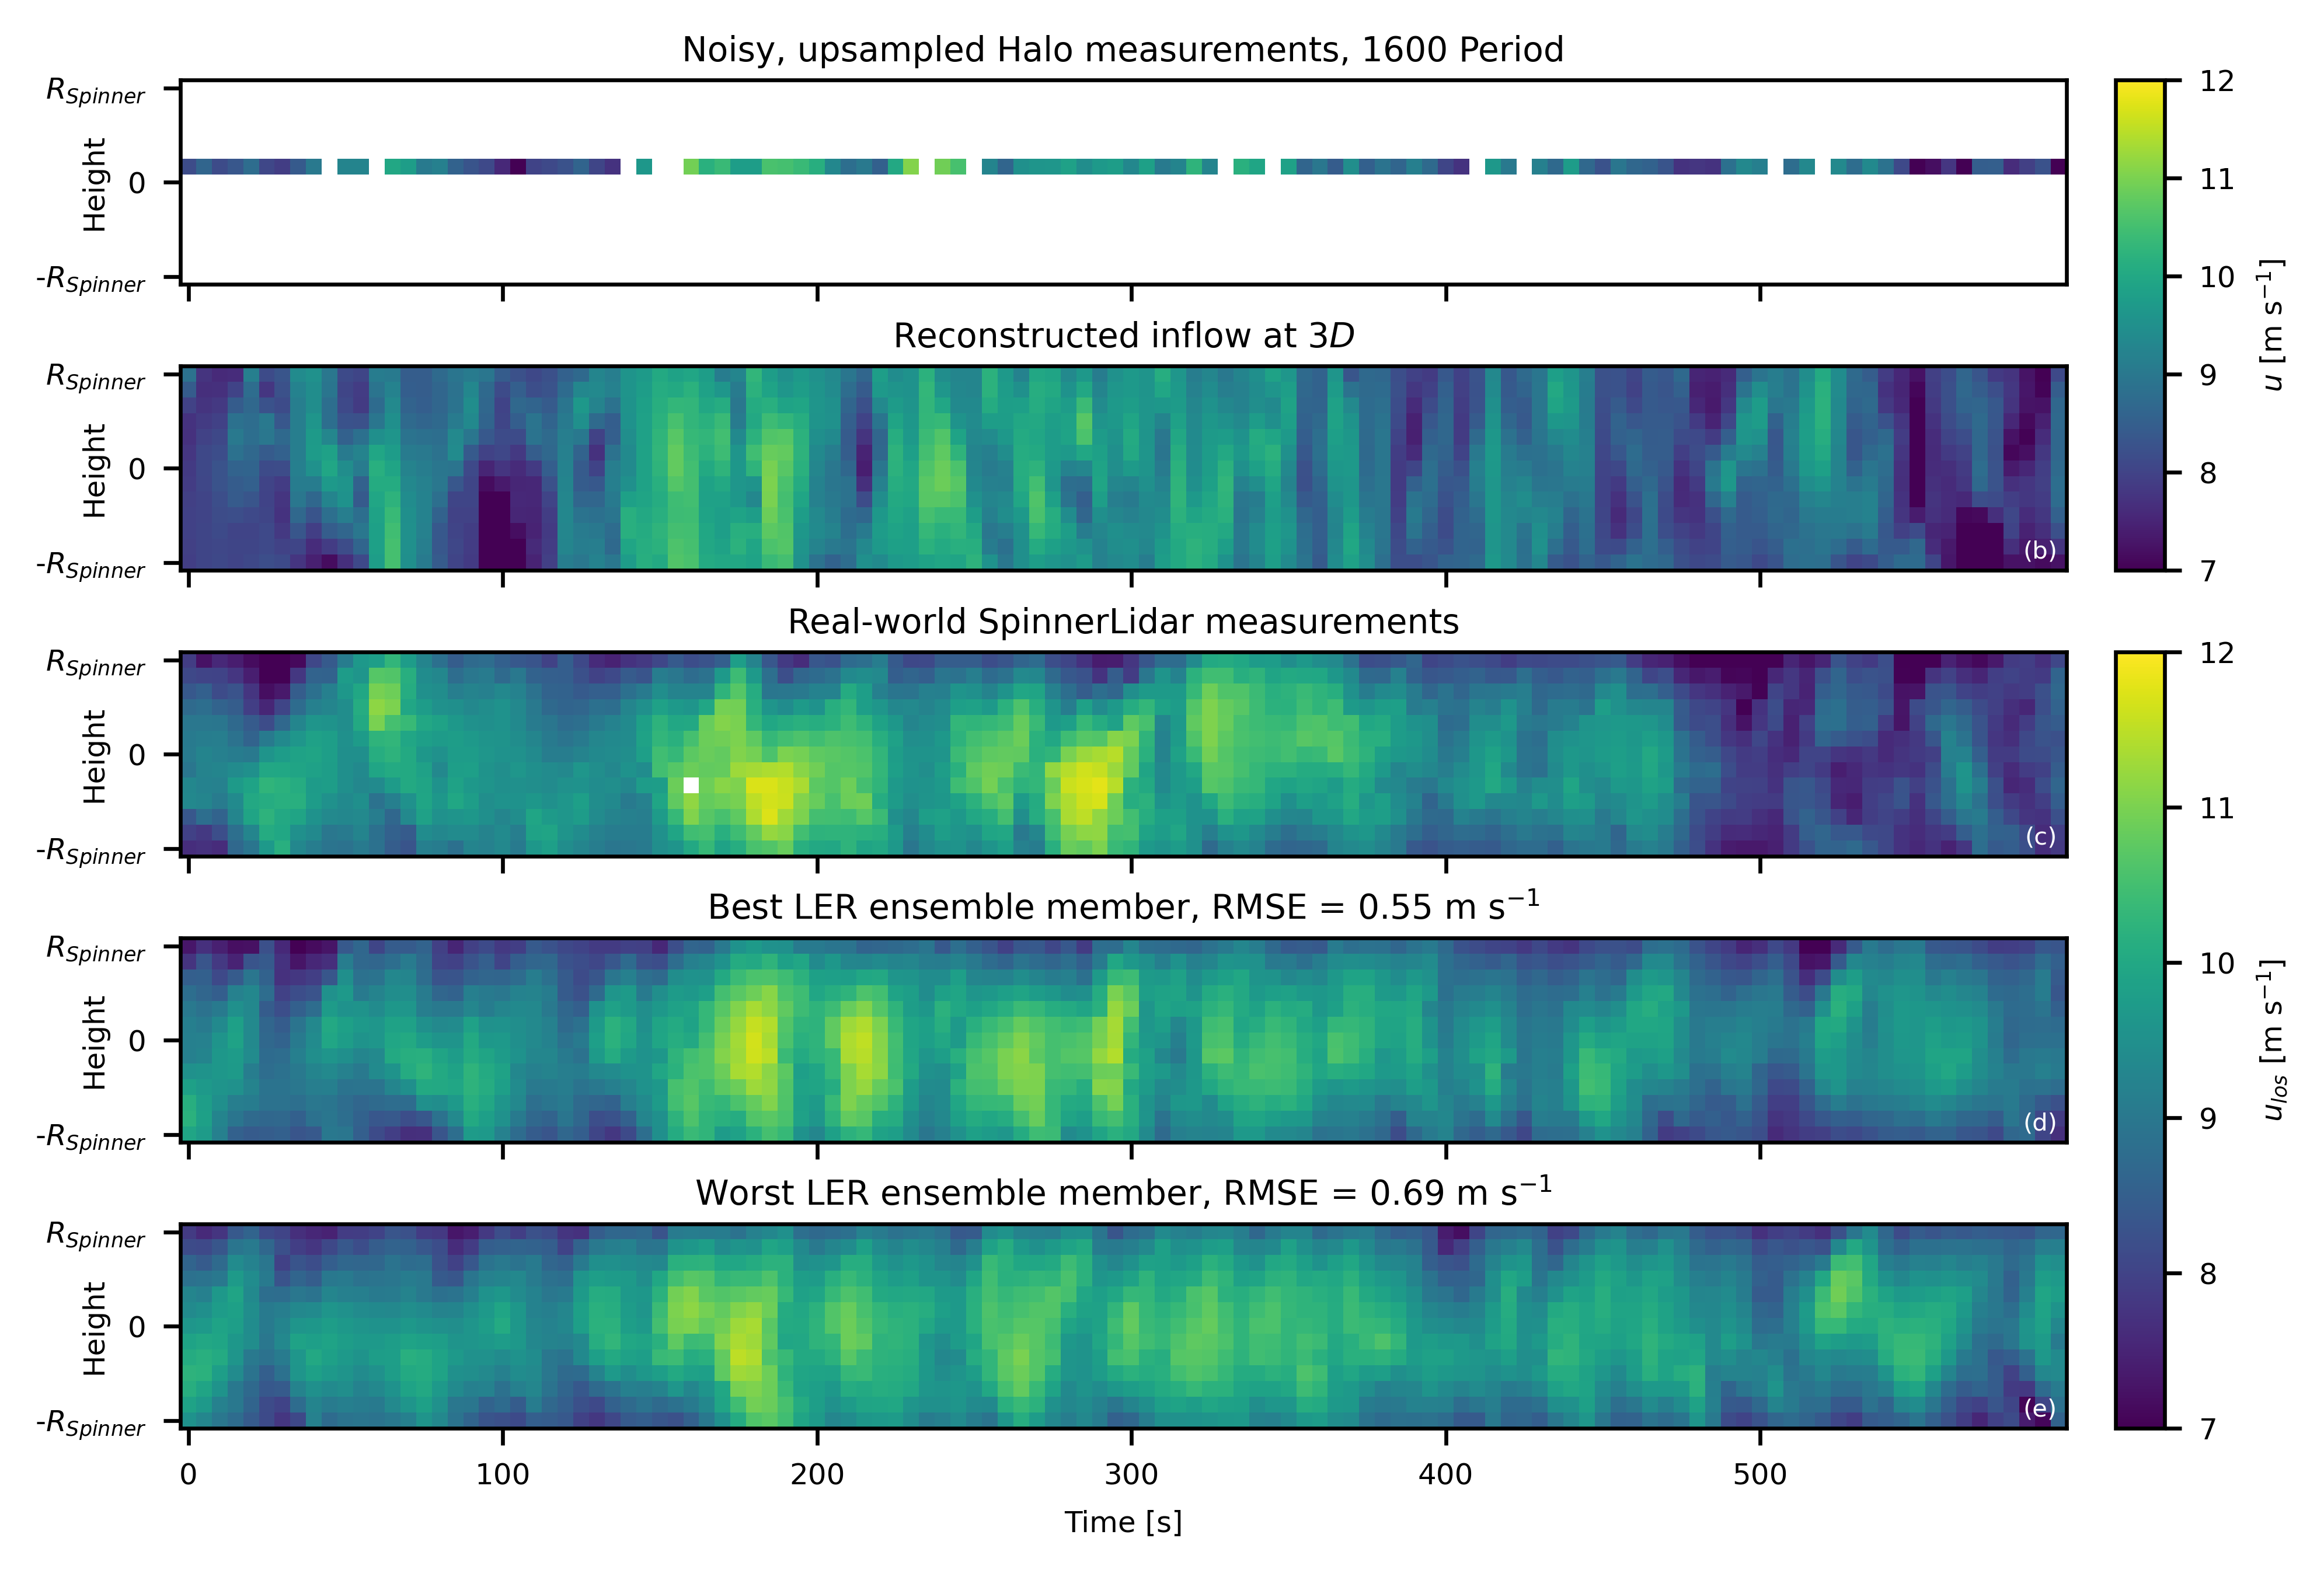

In [8]:
### Side views, with bonus denoised lidar plot
fig, ax = plt.subplots(5, 1, figsize=(7,5), dpi=600, sharex=True)

case_id = '1600 Period'
ds_halo = ds_halo3
ds_real = ds_real3
ds_mod = ds_mod3
ds_3D = ds_3D3

## Plot
pltvar = 'vlos'
pltmin, pltmax = 6, 11
yplt = 0
zplt = ds_real['z'].values[1:14]
plt.subplots_adjust(hspace=0.4)

# Calculate best/worst ensemble member
rmse_ens_plt = np.mean((ds_mod[pltvar] - ds_real[pltvar])**2, axis=(1,2,3)).values
iens_best = np.argmin(rmse_ens_plt)
iens_worst = np.argmax(rmse_ens_plt)

data0 = ds_halo['u'].sel(y=yplt,z=zplt).values.T
data1 = ds_3D['u_output'].sel(width=160, height=(zplt + 120)).isel(ens=iens_best).values
data1 = data1[::5,:]
data1 = data1[-120:,:]
data2 = ds_real[pltvar].sel(y=yplt,z=zplt).values.T
data3 = ds_mod[pltvar].sel(y=yplt,z=zplt).isel(ens=iens_best).values.T
data4 = ds_mod[pltvar].sel(y=yplt,z=zplt).isel(ens=iens_worst).values.T

im0 = ax[0].imshow(data0.T,
                   origin='lower',
                   vmin=7,
                   vmax=12)
im1 = ax[1].imshow(data1.T,
                   origin='lower',
                   vmin=7,
                   vmax=12)
im2 = ax[2].imshow(data2.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)
im3 = ax[3].imshow(data3.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)
im4 = ax[4].imshow(data4.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)


## Decorate
ax[0].set_title(f"Noisy, upsampled Halo measurements, {case_id}",fontsize=7,y=0.95)
ax[1].set_title(f"Reconstructed inflow at 3$D$",fontsize=7,y=0.95)
ax[2].set_title(f"Real-world SpinnerLidar measurements",fontsize=7,y=0.95)
ax[3].set_title(f"Best LER ensemble member, RMSE = {rmse_ens_plt[iens_best]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.95)
ax[4].set_title(f"Worst LER ensemble member, RMSE = {rmse_ens_plt[iens_worst]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.95)
ax[-1].set_xlabel("Time [s]",fontsize=6)

for axs in ax:
    yticks = np.array((0, 6, 12))
    axs.set_yticks(yticks)
    axs.set_yticklabels(['-$R_{Spinner}$', '0', '$R_{Spinner}$'])
    axs.set_ylabel("Height",fontsize=6,labelpad=-15)
    axs.tick_params('both',labelsize=6)
xticks = np.arange(0,120,20)
ax[-1].set_xticks(xticks)
ax[-1].set_xticklabels(5*xticks)

## Colorbar
cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
                     ax[1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$u$ [m s$^{-1}$]', fontsize=6)
cbar0.ax.tick_params(labelsize=6)

cax1 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[2].get_position().y1-ax[-1].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('$u_{los}$ [m s$^{-1}$]', fontsize=6)
cbar1.ax.tick_params(labelsize=6)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.995,
          0.059,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='white')
    
# plt.savefig('figs/spinner_qualitative_side_view.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/spinner_qualitative_side_view_1500.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/spinner_qualitative_side_view_1530.png', bbox_inches='tight', dpi=1000)
    
plt.show()

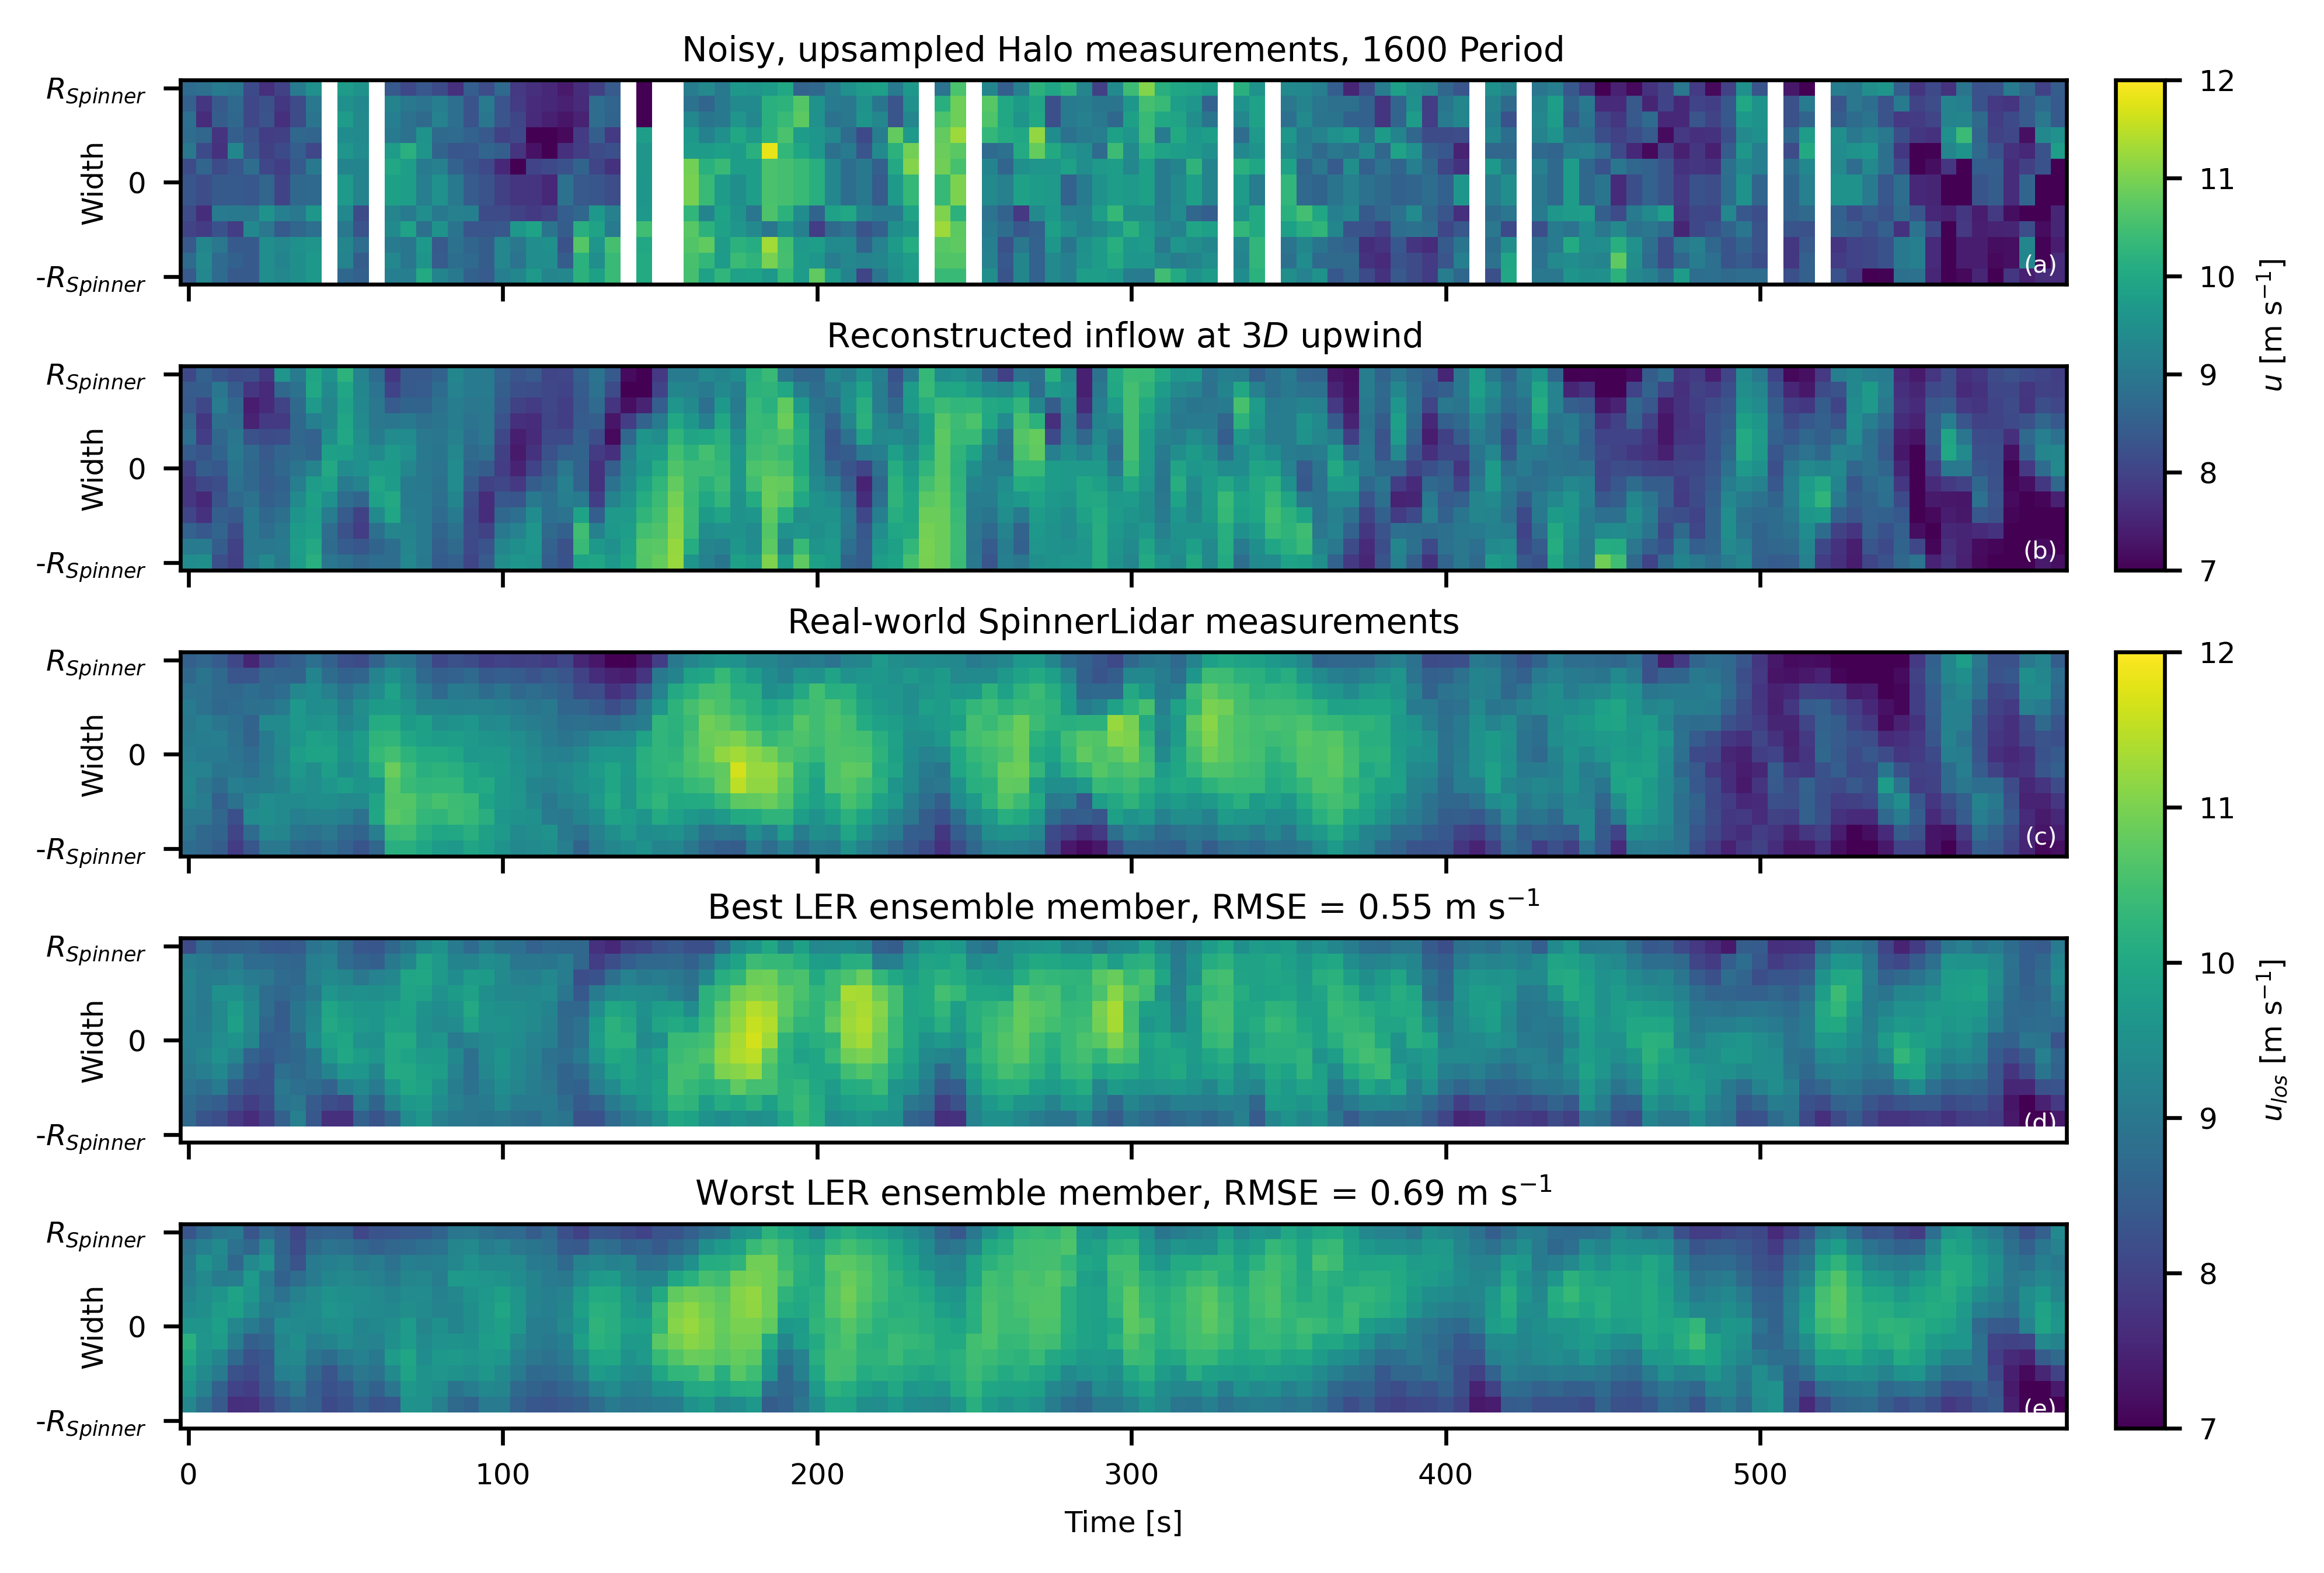

In [9]:
### Top-down, with bonus denoised lidar plot
fig, ax = plt.subplots(5, 1, figsize=(7,5), dpi=600, sharex=True)

case_id = '1600 Period'
ds_halo = ds_halo3
ds_real = ds_real3
ds_mod = ds_mod3
ds_3D = ds_3D3

## Plot
pltvar = 'vlos'
pltmin, pltmax = 6, 11
yplt = ds_real['y'].values[1:14]
zplt = 0
plt.subplots_adjust(hspace=0.4)
flag_flip = True  # reviewer wants this set to True


# Calculate best/worst ensemble member
rmse_ens_plt = np.mean((ds_mod[pltvar] - ds_real[pltvar])**2, axis=(1,2,3)).values
iens_best = np.argmin(rmse_ens_plt)
iens_worst = np.argmax(rmse_ens_plt)

data1 = ds_3D['u_output'].sel(width=(yplt+160), height=120).isel(ens=iens_best).values
data1 = data1[::5,:]
data1 = data1[-120:,:]
data1 = np.flip(data1, axis=1)
data0 = ds_halo['u'].sel(y=yplt,z=zplt).values.T
data2 = ds_real[pltvar].sel(y=yplt,z=zplt).values.T
data3 = ds_mod[pltvar].sel(y=yplt,z=zplt).isel(ens=iens_best).values.T
data4 = ds_mod[pltvar].sel(y=yplt,z=zplt).isel(ens=iens_worst).values.T


im0 = ax[0].imshow(data0.T,
                   origin='lower',
                   vmin=7,
                   vmax=12)
im1 = ax[1].imshow(data1.T,
                   origin='lower',
                   vmin=7,
                   vmax=12)
im2 = ax[2].imshow(data2.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)
im3 = ax[3].imshow(data3.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)
im4 = ax[4].imshow(data4.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)
# im0 = ax[0].imshow(data0.T,
#                    origin='lower',
#                    vmin=pltmin,
#                    vmax=pltmax,
#                    interpolation='catrom')
# im1 = ax[1].imshow(data1.T,
#                    origin='lower',
#                    vmin=pltmin,
#                    vmax=pltmax,
#                    interpolation='catrom')
# im2 = ax[2].imshow(data2.T,
#                    origin='lower',
#                    vmin=pltmin,
#                    vmax=pltmax,
#                    interpolation='catrom')


## Decorate
ax[0].set_title(f"Noisy, upsampled Halo measurements, {case_id}",fontsize=7,y=0.95)
ax[1].set_title(f"Reconstructed inflow at 3$D$ upwind",fontsize=7,y=0.95)
ax[2].set_title(f"Real-world SpinnerLidar measurements",fontsize=7,y=0.95)
ax[3].set_title(f"Best LER ensemble member, RMSE = {rmse_ens_plt[iens_best]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.95)
ax[4].set_title(f"Worst LER ensemble member, RMSE = {rmse_ens_plt[iens_worst]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.95)
ax[-1].set_xlabel("Time [s]",fontsize=6)

for axs in ax:
    yticks = np.array((0, 6, 12))
    axs.set_yticks(yticks)
    axs.set_yticklabels(['-$R_{Spinner}$', '0', '$R_{Spinner}$'])
    axs.set_ylabel("Width",fontsize=6,labelpad=-15)
    axs.tick_params('both',labelsize=6)
xticks = np.arange(0,120,20)
ax[-1].set_xticks(xticks)
ax[-1].set_xticklabels(5*xticks)

## Colorbar
cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
                     ax[1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$u$ [m s$^{-1}$]', fontsize=6)
cbar0.ax.tick_params(labelsize=6)

cax1 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[2].get_position().y1-ax[-1].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('$u_{los}$ [m s$^{-1}$]', fontsize=6)
cbar1.ax.tick_params(labelsize=6)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.995,
          0.059,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='white')
    
# plt.savefig('figs/spinner_qualitative_topdown_view.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/spinner_qualitative_topdown_view_1500.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/spinner_qualitative_topdown_view_flip.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/spinner_qualitative_topdown_view_1500_flip.png', bbox_inches='tight', dpi=1000)
    
plt.show()

Number of obs spanned for z=60, case=1: 70.83%
	Mean difference between the max and min ensemble wind speeds: 1.67 m/s
Number of obs spanned for z=60, case=2: 68.33%
	Mean difference between the max and min ensemble wind speeds: 1.58 m/s
Number of obs spanned for z=60, case=3: 69.17%
	Mean difference between the max and min ensemble wind speeds: 1.65 m/s
Number of obs spanned for z=0, case=1: 72.50%
	Mean difference between the max and min ensemble wind speeds: 1.22 m/s
Number of obs spanned for z=0, case=2: 85.83%
	Mean difference between the max and min ensemble wind speeds: 1.20 m/s
Number of obs spanned for z=0, case=3: 69.17%
	Mean difference between the max and min ensemble wind speeds: 1.17 m/s
Number of obs spanned for z=-60, case=1: 93.33%
	Mean difference between the max and min ensemble wind speeds: 1.96 m/s
Number of obs spanned for z=-60, case=2: 80.83%
	Mean difference between the max and min ensemble wind speeds: 1.67 m/s
Number of obs spanned for z=-60, case=3: 73.33%
	

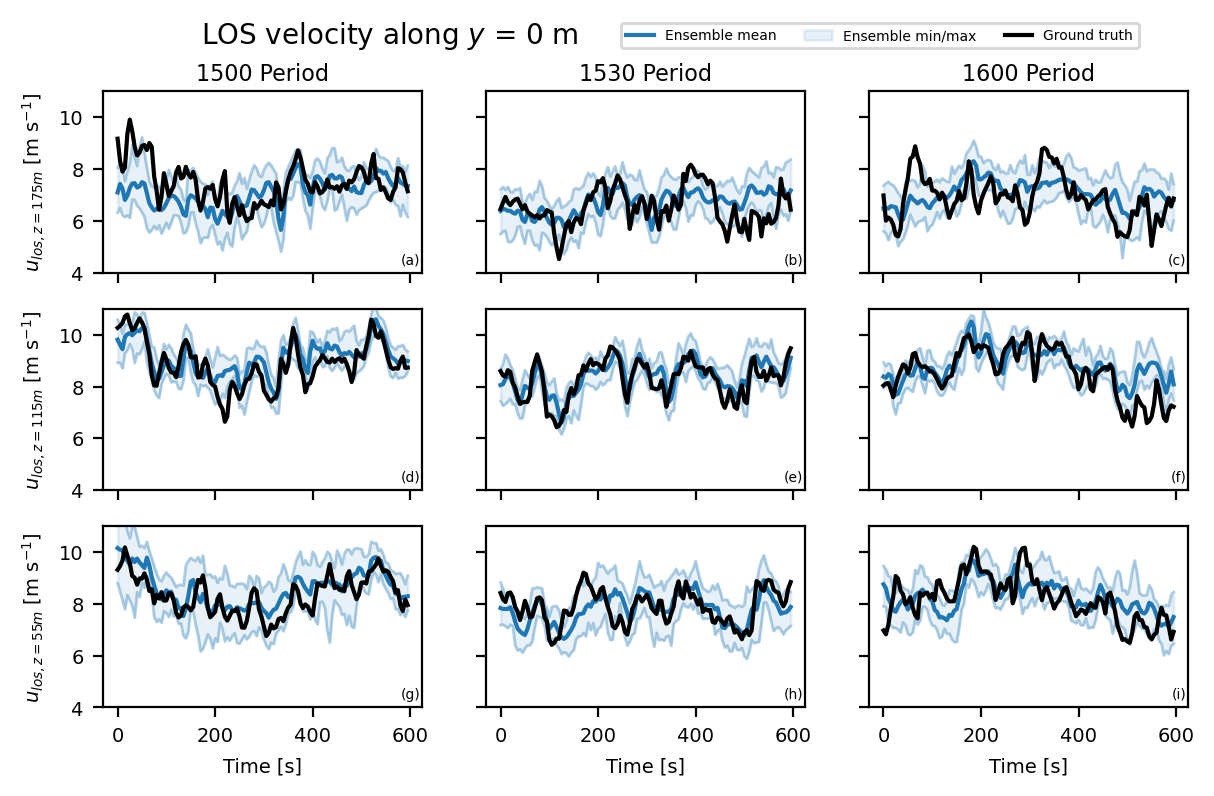

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(7,4), dpi=200, sharey=True, sharex=True)

pltvar = 'vlos'

ds_real = ds_real1
ds_mod = ds_mod1

t_plt = (ds_real['time'].values-ds_real['time'].values[0]).astype('timedelta64[s]').astype(int)

tot_num_obs_spanned = 0

for irow, zplt in enumerate([60, 0, -60]):
    for icol, ds_real, ds_mod in zip([0,1,2], [ds_real1,ds_real2,ds_real3], [ds_mod1,ds_mod2,ds_mod3]):
        ax[irow,icol].plot(t_plt,
                         ds_mod[pltvar].sel(z=zplt,y=0).mean('ens'),
                         color='C0',
                         label='Ensemble mean')
        ax[irow,icol].plot(t_plt,
                         ds_mod[pltvar].sel(z=zplt,y=0).max('ens'),
                         color='C0',
                         alpha=0.3,
                         linewidth=1)
        ax[irow,icol].plot(t_plt,
                         ds_mod[pltvar].sel(z=zplt,y=0).min('ens'),
                         color='C0',
                         alpha=0.3,
                         linewidth=1)
        ax[irow,icol].fill_between(t_plt,
                         ds_mod[pltvar].sel(z=zplt,y=0).min('ens'),
                         ds_mod[pltvar].sel(z=zplt,y=0).max('ens'),
                         color='C0',
                         alpha=0.1,
                         label='Ensemble min/max')
        num_obs_spanned = ((ds_real[pltvar].sel(z=zplt,y=0) < ds_mod[pltvar].sel(z=zplt,y=0).max('ens')) & (ds_real[pltvar].sel(z=zplt,y=0) > ds_mod[pltvar].sel(z=zplt,y=0).min('ens'))).sum().values
        pct_obs_spanned = 100 * num_obs_spanned / len(ds_mod['time'])
        print(f"Number of obs spanned for z={zplt}, case={icol+1}: {pct_obs_spanned:.2f}%")
        max_min_diff = (ds_mod[pltvar].sel(z=zplt,y=0).max('ens') - ds_mod[pltvar].sel(z=zplt,y=0).min('ens')).mean().values
        print(f"\tMean difference between the max and min ensemble wind speeds: {max_min_diff:.2f} m/s")

        ax[irow,icol].plot(t_plt,
                         ds_real[pltvar].sel(z=zplt,y=0),
                         color='k',
                         label='Ground truth')


for axs in ax.flatten():
    axs.tick_params('both',labelsize=8)
    
# for axs in ax[:,0]:
ax[0,0].set_ylabel("$u_{los, z=175 m}$ [m s$^{-1}$]", fontsize=7)
ax[1,0].set_ylabel("$u_{los, z=115 m}$ [m s$^{-1}$]", fontsize=7)
ax[2,0].set_ylabel("$u_{los, z=55 m}$ [m s$^{-1}$]", fontsize=7)
ax[0,0].set_title("1500 Period", fontsize=8, y=0.97)
ax[0,1].set_title("1530 Period", fontsize=8, y=0.97)
ax[0,2].set_title("1600 Period", fontsize=8, y=0.97)
    
for axs in ax.flatten():
    axs.tick_params('both',labelsize=7)
    
for axs in ax[-1,:]:
    axs.set_xlabel("Time [s]", fontsize=7)

plt.suptitle("LOS velocity along $y$ = 0 m", fontsize=10, y=0.97, x=0.33)
    
# ax[-1].set_xlabel("Time [UTC]", fontsize=8)
# myFmt = mdates.DateFormatter('%H%M')
# ax[-1].xaxis.set_major_formatter(myFmt)
    
# ax[0].set_title("-60 m", fontsize=7, y=0.95)
# ax[1].set_title("0 m", fontsize=7, y=0.95)
# ax[2].set_title("60 m", fontsize=7, y=0.95)
# plt.subplots_adjust(hspace=0.3)

handles, labels = ax[0,1].get_legend_handles_labels()
lgd = ax[0,1].legend(handles, labels, bbox_to_anchor=(0.4, 1.20), loc='lower left', fontsize=5, ncol=3)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.995,
          0.05,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')

ax[0,0].set_ylim(4, 11)
# ax[0,0].set_xlim(0, 200)

    
# plt.savefig('figs/real_timeseries_centerline.pdf', bbox_inches='tight')
        
plt.show()

# Profiles of correlation, 1st order stats, and 2nd order stats

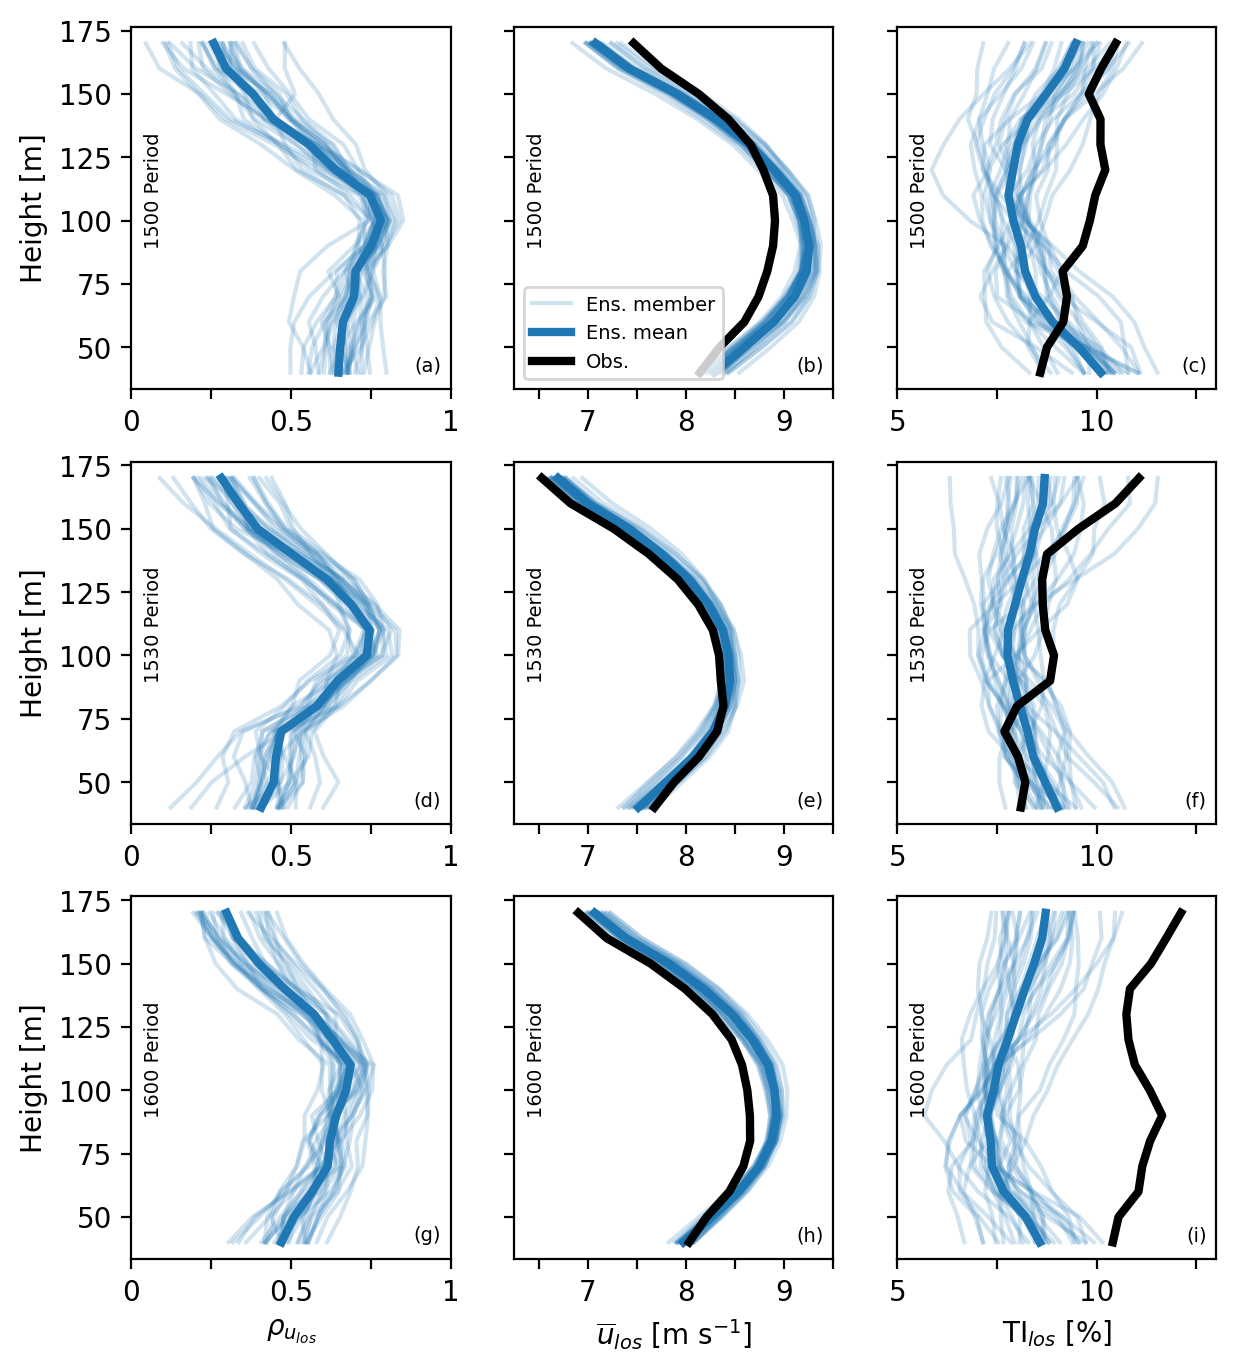

In [19]:
fig, ax = plt.subplots(3, 3, figsize=(7,8), dpi=200, sharey=True)

for axs in ax[:,0]:
    axs.set_ylabel("Height [m]")

ax[-1,0].set_xlabel('$\\rho_{u_{los}}$')
ax[-1,1].set_xlabel('$\overline{u}_{los}$ [m s$^{-1}$]')
# ax[-1,2].set_xlabel('$\sigma_{{u}_{los}}$ [m s$^{-1}$]')
ax[-1,2].set_xlabel('TI$_{los}$ [%]')

# ax[0,0].set_ylim(-80,70)
for axs in ax[:,0]:
    axs.set_xlim(0,1)
for axs in ax[:,1]:
    axs.set_xlim(6.25,9.5)
for axs in ax[:,2]:
    axs.set_xlim(5,13)

for irow, ds_real, ds_mod in zip([0,1,2], [ds_real1,ds_real2,ds_real3], [ds_mod1,ds_mod2,ds_mod3]):
    corr_y = 0
    corr_profile = np.zeros((len(ds_mod['z']), len(ds_mod['ens'])))
    for k, z in enumerate(ds_mod['z']):
        corr_profile[k,:] = xr.corr(ds_real['vlos'].sel(y=corr_y,z=z), ds_mod['vlos'].sel(y=corr_y,z=z), dim='time').values[:].copy()
    
    ax[irow,0].plot(corr_profile,
               ds_real['z']+110,
               color='C0',
               alpha=0.2)
    ax[irow,0].plot(corr_profile.mean(axis=1),
               ds_real['z']+110,
               color='C0',
               linewidth=3)
    
    for iens in range(30):
        if iens == 0:
            ax[irow,1].plot(ds_mod['vlos'].sel(ens=iens,y=0).mean('time'),
                       ds_mod['z']+110,
                       color='C0',
                       alpha=0.2,
                       label='Ens. member')
        else:
            ax[irow,1].plot(ds_mod['vlos'].sel(ens=iens,y=0).mean('time'),
                       ds_mod['z']+110,
                       color='C0',
                       alpha=0.2)
    ax[irow,1].plot(ds_mod['vlos'].sel(y=0).mean(('time', 'ens')),
               ds_mod['z']+110,
               color='C0',
               linewidth=3,
               label='Ens. mean')
    ax[irow,1].plot(ds_real['vlos'].sel(y=0).mean(('time')),
               ds_real['z']+110,
               color='k',
               linewidth=3,
               label='Obs.')

    # # Standard deviation
    # for iens in range(30):
    #     ax[irow,2].plot(ds_mod['vlos'].sel(ens=iens,y=0).std('time'),
    #                ds_mod['z']+110,
    #                color='C0',
    #                alpha=0.2)
    # ax[irow,2].plot(ds_mod['vlos'].sel(y=0).std('time').mean('ens'),
    #            ds_mod['z']+110,
    #            color='C0',
    #            linewidth=3)
    # ax[irow,2].plot(ds_real['vlos'].sel(y=0).std(('time')),
    #            ds_real['z']+110,
    #            color='k',
    #            linewidth=3)
    
    # TI
    for iens in range(30):
        ax[irow,2].plot(100*ds_mod['vlos'].sel(ens=iens,y=0).std('time')/ds_mod['vlos'].sel(ens=iens,y=0).mean('time'),
                   ds_mod['z']+110,
                   color='C0',
                   alpha=0.2)
    ax[irow,2].plot(100*(ds_mod['vlos'].sel(y=0).std('time')/ds_mod['vlos'].sel(y=0).mean('time')).mean('ens'),
               ds_mod['z']+110,
               color='C0',
               linewidth=3)
    ax[irow,2].plot(100*ds_real['vlos'].sel(y=0).std(('time'))/ds_real['vlos'].sel(y=0).mean(('time')),
               ds_real['z']+110,
               color='k',
               linewidth=3)

# ax[0].set_xlim(-0.5, 1.0)
# ax[2].set_xlim(0, 0.8)

for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.97,
          0.05,
          f'({letter})',
          fontsize=7,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')
    
for axs in ax[0,:]:
    axs.text(0.1,
             0.4,
             '1500 Period',
             fontsize=7,
             transform = axs.transAxes,
             horizontalalignment='right',
             color='k',
             rotation=90)
for axs in ax[1,:]:
    axs.text(0.1,
             0.4,
             '1530 Period',
             fontsize=7,
             transform = axs.transAxes,
             horizontalalignment='right',
             color='k',
             rotation=90)
for axs in ax[2,:]:
    axs.text(0.1,
             0.4,
             '1600 Period',
             fontsize=7,
             transform = axs.transAxes,
             horizontalalignment='right',
             color='k',
             rotation=90)
    
ax[0,1].legend(fontsize=7,
              loc='lower left')
    
ax[0,0].set_xticks([0, 0.25, 0.5, 0.75, 1])
ax[1,0].set_xticks([0, 0.25, 0.5, 0.75, 1])
ax[2,0].set_xticks([0, 0.25, 0.5, 0.75, 1])
ax[0,0].set_xticklabels([0, None, 0.5, None, 1])
ax[1,0].set_xticklabels([0, None, 0.5, None, 1])
ax[2,0].set_xticklabels([0, None, 0.5, None, 1])

ax[0,1].set_xticks([6.5, 7, 7.5, 8, 8.5, 9, 9.5])
ax[1,1].set_xticks([6.5, 7, 7.5, 8, 8.5, 9, 9.5])
ax[2,1].set_xticks([6.5, 7, 7.5, 8, 8.5, 9, 9.5])
ax[0,1].set_xticklabels([None, 7, None, 8, None, 9, None])
ax[1,1].set_xticklabels([None, 7, None, 8, None, 9, None])
ax[2,1].set_xticklabels([None, 7, None, 8, None, 9, None])

ax[0,2].set_xticks([5, 7.5, 10, 12.5])
ax[1,2].set_xticks([5, 7.5, 10, 12.5])
ax[2,2].set_xticks([5, 7.5, 10, 12.5])
ax[0,2].set_xticklabels([5, None, 10, None])
ax[1,2].set_xticklabels([5, None, 10, None])
ax[2,2].set_xticklabels([5, None, 10, None])
    
# plt.savefig('figs/real_profile_validation.pdf')

plt.show()

# Pixel-by-pixel error histogram

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3), dpi=200, sharey=True)

ax.set_box_aspect(1)
# axs.set_yticks([])
# axs.set_yticklabels([])
    
bins_err = np.arange(-3.5, 3.5, 0.1)

err1 = (ds_mod1['vlos'] - ds_real1['vlos']).values.flatten()
err2 = (ds_mod2['vlos'] - ds_real2['vlos']).values.flatten()
err3 = (ds_mod3['vlos'] - ds_real3['vlos']).values.flatten()
ax.hist(err1, bins=bins_err, edgecolor='C0', facecolor='none', label='1500 Period', histtype='step')
ax.hist(err2, bins=bins_err, edgecolor='C1', facecolor='none', label='1530 Period', histtype='step')
ax.hist(err3, bins=bins_err, edgecolor='C2', facecolor='none', label='1600 Period', histtype='step')
ax.axvline(0, color='C3', ls='--', linewidth=1)
ax.set_xlabel("Error [m s$^{-1}$]", fontsize=7)
ax.tick_params('both',labelsize=7)

ax.set_ylabel("Count", fontsize=7)
ax.legend(fontsize=7)

# plt.savefig('figs/real_histogram.pdf', bbox_inches='tight')

print(f"1500 mean error = {np.nanmean(err1):.2f} m/s, std dev = {np.nanstd(err1):.2f} m/s")
print(f"1530 mean error = {np.nanmean(err2):.2f} m/s, std dev = {np.nanstd(err2):.2f} m/s")
print(f"1600 mean error = {np.nanmean(err3):.2f} m/s, std dev = {np.nanstd(err3):.2f} m/s")
    
plt.show()

# Power spectra

In [ ]:
# fig, ax = plt.subplots(3, 1, figsize=(3.5,8), dpi=200, sharey=True)
fig, ax = plt.subplots(1, 3, figsize=(7, 3.5), dpi=200, sharey=True)

for axs in ax:
    axs.set_box_aspect(1)
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_ylim(1e-3, 5e1)
    axs.set_ylabel('Power spectral density $E(k)$', fontsize=7)
    axs.tick_params('both',labelsize=7)
    
ax[-1].set_xlabel('Wavenumber [k]', fontsize=7)


for iax, ds_real, ds_mod in zip([0,1,2], [ds_real1,ds_real2,ds_real3], [ds_mod1, ds_mod2, ds_mod3]):
    ## Calculate power spectra
    # Parameters
    yspectra = 0
    zspectra = 0
    Ntime = len(ds_real['time'])
    fs = 0.2  # Hz
    freq_axis = np.fft.fftfreq(Ntime, 1/fs)

    # Real spectrum
    real_vlos_ts = ds_real['vlos'].sel(y=yspectra,z=zspectra).values
    real_vlos_mean = np.mean(real_vlos_ts)  # Calculate the mean of the data
    real_vlos_fluctuations = real_vlos_ts - real_vlos_mean  # Remove the mean to obtain fluctuations

    fft_real = np.fft.fft(real_vlos_fluctuations)
    power_spectrum_real = (np.abs(fft_real)**2) / Ntime

    # Modeled spectrum
    mod_vlos_ts = ds_mod['vlos'].sel(y=yspectra,z=zspectra).values
    mod_vlos_mean = np.mean(mod_vlos_ts, axis=1)  # Calculate the mean of the data
    mod_vlos_fluctuations = mod_vlos_ts - mod_vlos_mean[:,np.newaxis]  # Remove the mean to obtain fluctuations

    fft_mod = np.zeros((30, len(fft_real)))
    power_spectrum_mod = np.zeros((30, len(power_spectrum_real)))
    for iens in range(30):
        fft_mod[iens,:] = np.fft.fft(mod_vlos_fluctuations[iens,:]).copy()
        power_spectrum_mod[iens,:] = ((np.abs(fft_mod[iens,:])**2) / Ntime).copy()

    # Calculate average modeled spectrum
    freq_min = np.min(freq_axis[1:Ntime//2])
    freq_max = np.max(freq_axis[1:Ntime//2])
    avg_freq_bins = np.logspace(np.log10(freq_min), np.log10(freq_max), num=10)

    interpolated_spectra = np.zeros((30, len(avg_freq_bins)))
    min_mod_spectrum = np.zeros_like(avg_freq_bins)
    max_mod_spectrum = np.zeros_like(avg_freq_bins)
    for iens in range(30):
        interpolated_spectra[iens,:] = np.interp(avg_freq_bins, freq_axis[1:Ntime//2], power_spectrum_mod[iens,1:Ntime//2]).copy()
    power_spectrum_mod_avg = np.mean(interpolated_spectra, axis=0)
    power_spectrum_mod_min = np.min(interpolated_spectra, axis=0)
    power_spectrum_mod_max = np.max(interpolated_spectra, axis=0)
    
    ## Plot!
    # for iens in range(2,3):
    # for iens in range(0,20):
        # ax[iax].plot(freq_axis[1:Ntime//2], power_spectrum_mod[iens,1:Ntime//2], color='C0', label='1 Reconstruction', alpha=0.2)
    ax[iax].plot(avg_freq_bins[1:Ntime//2], power_spectrum_mod_avg[1:Ntime//2], color='C0', label='Avg. reconstruction')
    ax[iax].plot(avg_freq_bins[1:Ntime//2], power_spectrum_mod_max[1:Ntime//2], color='C0', label='Max reconstruction', alpha=0.4)
    ax[iax].fill_between(avg_freq_bins[1:Ntime//2],
                    power_spectrum_mod_avg[1:Ntime//2],
                    power_spectrum_mod_max[1:Ntime//2],
                    color='C0',
                    alpha=0.2)

    ax[iax].plot(freq_axis[1:Ntime//2], power_spectrum_real[1:Ntime//2], color='k', label='Ground truth')
    ax[iax].plot(freq_axis[1:Ntime//2], 1e-3*freq_axis[1:Ntime//2]**(-5/3), ls='--', label='-5/3', color='C1')


ax[0].text(0.97,
         0.93,
         '1500 Period',
         fontsize=6,
         transform = ax[0].transAxes,
         horizontalalignment='right',
         color='k',
         rotation=0)
ax[1].text(0.97,
         0.93,
         '1530 Period',
         fontsize=6,
         transform = ax[1].transAxes,
         horizontalalignment='right',
         color='k',
         rotation=0)
ax[2].text(0.97,
         0.93,
         '1600 Period',
         fontsize=6,
         transform = ax[2].transAxes,
         horizontalalignment='right',
         color='k',
         rotation=0)


ax[0].legend(fontsize=5)

plt.savefig('figs/real_spectra.png', dpi=300, bbox_inches='tight')
# plt.savefig('figs/real_spectra.pdf', bbox_inches='tight')

plt.show()

In [ ]:
### Plot 3 periods, but average hub-height data
fig, ax = plt.subplots(1, 3, figsize=(7, 3.5), dpi=200, sharey=True)

for axs in ax:
    axs.set_box_aspect(1)
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_ylim(1e-3, 5e1)
    axs.set_ylabel('Power spectral density $E(k)$', fontsize=7)
    axs.tick_params('both',labelsize=7)
    axs.set_xlabel('Wavenumber [k]', fontsize=7)


for iax, ds_real, ds_mod in zip([0,1,2], [ds_real1,ds_real2,ds_real3], [ds_mod1, ds_mod2, ds_mod3]):
    ## Calculate power spectra
    # Parameters
    real_spectrum_list = []
    mod_mean_spectrum_list = []
    mod_max_spectrum_list = []
    ysweep = np.arange(-50, 60, 10)
    for yspectra in ysweep:
        zspectra = 0
        Ntime = len(ds_real['time'])
        fs = 0.2  # Hz
        freq_axis = np.fft.fftfreq(Ntime, 1/fs)

        # Real spectrum
        real_vlos_ts = ds_real['vlos'].sel(y=yspectra,z=zspectra).values
        real_vlos_mean = np.mean(real_vlos_ts)  # Calculate the mean of the data
        real_vlos_fluctuations = real_vlos_ts - real_vlos_mean  # Remove the mean to obtain fluctuations

        fft_real = np.fft.fft(real_vlos_fluctuations)
        power_spectrum_real = (np.abs(fft_real)**2) / Ntime
        real_spectrum_list.append(power_spectrum_real.copy())

        # Modeled spectrum
        mod_vlos_ts = ds_mod['vlos'].sel(y=yspectra,z=zspectra).values
        mod_vlos_mean = np.mean(mod_vlos_ts, axis=1)  # Calculate the mean of the data
        mod_vlos_fluctuations = mod_vlos_ts - mod_vlos_mean[:,np.newaxis]  # Remove the mean to obtain fluctuations

        fft_mod = np.zeros((30, len(fft_real)))
        power_spectrum_mod = np.zeros((30, len(power_spectrum_real)))
        for iens in range(30):
            fft_mod[iens,:] = np.fft.fft(mod_vlos_fluctuations[iens,:]).copy()
            power_spectrum_mod[iens,:] = ((np.abs(fft_mod[iens,:])**2) / Ntime).copy()

        # Calculate average modeled spectrum
        freq_min = np.min(freq_axis[1:Ntime//2])
        freq_max = np.max(freq_axis[1:Ntime//2])
        avg_freq_bins = np.logspace(np.log10(freq_min), np.log10(freq_max), num=10)

        interpolated_spectra = np.zeros((30, len(avg_freq_bins)))
        min_mod_spectrum = np.zeros_like(avg_freq_bins)
        max_mod_spectrum = np.zeros_like(avg_freq_bins)
        for iens in range(30):
            interpolated_spectra[iens,:] = np.interp(avg_freq_bins, freq_axis[1:Ntime//2], power_spectrum_mod[iens,1:Ntime//2]).copy()
        power_spectrum_mod_avg = np.mean(interpolated_spectra, axis=0)
        power_spectrum_mod_min = np.min(interpolated_spectra, axis=0)
        power_spectrum_mod_max = np.max(interpolated_spectra, axis=0)
    
        mod_mean_spectrum_list.append(power_spectrum_mod_avg.copy())
        mod_max_spectrum_list.append(power_spectrum_mod_max.copy())
    
    ## Average over y
    mean_real_spectrum = np.array(real_spectrum_list).mean(axis=0)
    mean_mod_mean_spectrum = np.array(mod_mean_spectrum_list).mean(axis=0)
    mean_mod_max_spectrum = np.array(mod_max_spectrum_list).mean(axis=0)
    
    ## Plot!
    # ax[iax].plot(avg_freq_bins[1:Ntime//2], power_spectrum_mod_avg[1:Ntime//2], color='C0', label='Avg. reconstruction')
    # ax[iax].plot(avg_freq_bins[1:Ntime//2], power_spectrum_mod_max[1:Ntime//2], color='C0', label='Max reconstruction', alpha=0.4)
    # ax[iax].fill_between(avg_freq_bins[1:Ntime//2],
    #                 power_spectrum_mod_avg[1:Ntime//2],
    #                 power_spectrum_mod_max[1:Ntime//2],
    #                 color='C0',
    #                 alpha=0.2)
    
    ax[iax].plot(avg_freq_bins[1:Ntime//2], mean_mod_mean_spectrum[1:Ntime//2], color='C0', label='Avg. reconstruction')
    ax[iax].plot(avg_freq_bins[1:Ntime//2], mean_mod_max_spectrum[1:Ntime//2], color='C0', label='Max reconstruction', alpha=0.4)
    ax[iax].fill_between(avg_freq_bins[1:Ntime//2],
                    mean_mod_mean_spectrum[1:Ntime//2],
                    mean_mod_max_spectrum[1:Ntime//2],
                    color='C0',
                    alpha=0.2)

    # ax[iax].plot(freq_axis[1:Ntime//2], power_spectrum_real[1:Ntime//2], color='k', alpha=0.1)
    ax[iax].plot(freq_axis[1:Ntime//2], mean_real_spectrum[1:Ntime//2], color='k', label='Ground truth')
    ax[iax].plot(freq_axis[1:Ntime//2], 1e-3*freq_axis[1:Ntime//2]**(-5/3), ls='--', label='-5/3', color='C1')


ax[0].text(0.97,
         0.93,
         '1500 Period',
         fontsize=6,
         transform = ax[0].transAxes,
         horizontalalignment='right',
         color='k',
         rotation=0)
ax[1].text(0.97,
         0.93,
         '1530 Period',
         fontsize=6,
         transform = ax[1].transAxes,
         horizontalalignment='right',
         color='k',
         rotation=0)
ax[2].text(0.97,
         0.93,
         '1600 Period',
         fontsize=6,
         transform = ax[2].transAxes,
         horizontalalignment='right',
         color='k',
         rotation=0)


ax[0].legend(fontsize=5)

# plt.savefig('figs/real_spectra_3_periods.pdf', bbox_inches='tight')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(7,3.5), dpi=200, sharey=True)

for axs in ax:
    axs.set_box_aspect(1)
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_ylim(1e-3, 5e1)
    axs.tick_params('both',labelsize=7)    
    axs.set_xlabel('Wavenumber [k]', fontsize=7)
ax[0].set_ylabel('Power spectral density $E(k)$', fontsize=7)

    
ds_real = ds_real3
ds_mod = ds_mod3

for iax, zspectra, ds_mod in zip([0,1,2], [60, 0, -60], [ds_mod1, ds_mod2, ds_mod3]):
    ## Calculate power spectra
    # Parameters
    yspectra = 0
    Ntime = len(ds_real['time'])
    fs = 0.2  # Hz
    freq_axis = np.fft.fftfreq(Ntime, 1/fs)

    # Real spectrum
    real_vlos_ts = ds_real['vlos'].sel(y=yspectra,z=zspectra).values
    real_vlos_mean = np.mean(real_vlos_ts)  # Calculate the mean of the data
    real_vlos_fluctuations = real_vlos_ts - real_vlos_mean  # Remove the mean to obtain fluctuations

    fft_real = np.fft.fft(real_vlos_fluctuations)
    power_spectrum_real = (np.abs(fft_real)**2) / Ntime

    # Modeled spectrum
    mod_vlos_ts = ds_mod['vlos'].sel(y=yspectra,z=zspectra).values
    mod_vlos_mean = np.mean(mod_vlos_ts, axis=1)  # Calculate the mean of the data
    mod_vlos_fluctuations = mod_vlos_ts - mod_vlos_mean[:,np.newaxis]  # Remove the mean to obtain fluctuations

    fft_mod = np.zeros((30, len(fft_real)))
    power_spectrum_mod = np.zeros((30, len(power_spectrum_real)))
    for iens in range(30):
        fft_mod[iens,:] = np.fft.fft(mod_vlos_fluctuations[iens,:]).copy()
        power_spectrum_mod[iens,:] = ((np.abs(fft_mod[iens,:])**2) / Ntime).copy()

    # Calculate average modeled spectrum
    freq_min = np.min(freq_axis[1:Ntime//2])
    freq_max = np.max(freq_axis[1:Ntime//2])
    avg_freq_bins = np.logspace(np.log10(freq_min), np.log10(freq_max), num=10)

    interpolated_spectra = np.zeros((30, len(avg_freq_bins)))
    min_mod_spectrum = np.zeros_like(avg_freq_bins)
    max_mod_spectrum = np.zeros_like(avg_freq_bins)
    for iens in range(30):
        interpolated_spectra[iens,:] = np.interp(avg_freq_bins, freq_axis[1:Ntime//2], power_spectrum_mod[iens,1:Ntime//2]).copy()
    power_spectrum_mod_avg = np.mean(interpolated_spectra, axis=0)
    power_spectrum_mod_min = np.min(interpolated_spectra, axis=0)
    power_spectrum_mod_max = np.max(interpolated_spectra, axis=0)
    
    ## Plot!
    # for iens in range(2,3):
    # for iens in range(0,20):
        # ax[iax].plot(freq_axis[1:Ntime//2], power_spectrum_mod[iens,1:Ntime//2], color='C0', label='1 Reconstruction', alpha=0.2)
    ax[iax].plot(avg_freq_bins[1:Ntime//2], power_spectrum_mod_avg[1:Ntime//2], color='C0', label='Avg. reconstruction')
    ax[iax].plot(avg_freq_bins[1:Ntime//2], power_spectrum_mod_max[1:Ntime//2], color='C0', label='Max reconstruction', alpha=0.4)
    ax[iax].fill_between(avg_freq_bins[1:Ntime//2],
                    power_spectrum_mod_avg[1:Ntime//2],
                    power_spectrum_mod_max[1:Ntime//2],
                    color='C0',
                    alpha=0.2)

    ax[iax].plot(freq_axis[1:Ntime//2], power_spectrum_real[1:Ntime//2], color='k', label='Ground truth')
    ax[iax].plot(freq_axis[1:Ntime//2], 1e-3*freq_axis[1:Ntime//2]**(-5/3), ls='--', label='-5/3', color='C1')


ax[0].text(0.97,
         0.93,
         '(a) Rotor top',
         fontsize=6,
         transform = ax[0].transAxes,
         horizontalalignment='right',
         color='k',
         rotation=0)
ax[1].text(0.97,
         0.93,
         '(b) Hub-height',
         fontsize=6,
         transform = ax[1].transAxes,
         horizontalalignment='right',
         color='k',
         rotation=0)
ax[2].text(0.97,
         0.93,
         '(c) Rotor bottom',
         fontsize=6,
         transform = ax[2].transAxes,
         horizontalalignment='right',
         color='k',
         rotation=0)


ax[0].legend(fontsize=5)

# plt.savefig('figs/real_spectra.pdf', bbox_inches='tight')

plt.show()